In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import math

#this number can be played with for new results if we have time
SMOOTHING_FACTOR = 0.9

class Dataset:
    def __init__(self, images_file, labels_file, lines_per_image = 28):
        self.images = []
        self.labels = []
        self.images_by_label = {}
        self.priors = {}
        with open(images_file) as file:
            EOF = False
            while not EOF:
                image = []
                for i in range(lines_per_image):
                    line = file.readline()
                    if not line:
                        EOF = True
                        break
                    image.append(list(line))
                if EOF:
                    break
                self.images.append(image)
        with open(labels_file) as file:
            for line in file:
                self.labels.append(line)
    def display(self, i):
        print("".join(map(lambda x: "".join(x),self.images[i])))
        
class Classifier:
    def __init__(self, label, hMap, prior):
        self.label = label
        self.hMap = hMap
        self.prior = prior
    
    def evaluate_likelihood(self, image):
        total = math.log10(self.prior)
        for i in range(self.hMap.mapSize):
            for j in range(self.hMap.mapSize):
                partial_eval = self.single_probability(i, j, image[i][j])
                total += math.log10(partial_eval)
        return total
    
    def printImage(self, image):
        print("".join(map(lambda x: "".join(x),image)))
    
    def single_probability(self, x, y, testPixel):
        if(testPixel == ' '):
            #testVal = 0
            #number of times a pixel is 0 from all the training examples
            instances = self.hMap.totalExamples - self.hMap.hMap_count[x][y]
            return float(instances / self.hMap.totalExamples)
        elif testPixel != "\n":
            #testVal = 1
            instances = self.hMap.hMap_count[x][y]
            return float(instances / self.hMap.totalExamples)
            
            
class HeatMap:
    def __init__(self, label, mapSize = 28):
        self.hMap_count = [[SMOOTHING_FACTOR for i in range(mapSize)] for j in range(mapSize)]
        self.label = label
        self.mapSize = mapSize
        self.totalExamples = 2*SMOOTHING_FACTOR
                    
    def printHMap(self, smoothed = True):
        print("Heat map for digit: " + str(self.label) + " from " + str(self.totalExamples) + " examples")
        for i in range(self.mapSize):
            if smoothed:
                toPrint = ""
                for j in range(self.mapSize):
                    if self.hMap_count[i][j] < 1:
                        toPrint += " "
                    elif self.hMap_count[i][j] < 80:
                        toPrint += "*"
                    else:
                        toPrint += "X"
                print(toPrint)
                
            else:
                toPrint = ""
                for j in range(self.mapSize):
                    if self.hMap_count[i][j] < 3:
                        toPrint += " "
                    elif self.hMap_count[i][j] < 80:
                        toPrint += "*"
                    else:
                        toPrint += "X"
                print(toPrint)

    def addToHMap(self, image):
        self.totalExamples += 1
        for i in range(self.mapSize):
            for j in range(self.mapSize):
                if(image[i][j] != ' '):
                    self.hMap_count[i][j] += 1
                
    def labelProbability(self, trainingSetSize = 5000):
        return (self.totalExamples-2*SMOOTHING_FACTOR) / trainingSetSize
    
    def goodHMap(self):
        for i in range(self.mapSize):
            for j in range(self.mapSize):
                if(self.hMap_smoothed[i][j] <= 0):
                    return False
        
        return True

            
        

In [3]:
dataset = Dataset("trainingimages","traininglabels")

In [4]:
digitHMaps = [None]*10
for i in range(0,10):
    digitHMaps[i] = HeatMap(i)

for i  in range(len(dataset.images)):
    currLabel = int(dataset.labels[i])
    digitHMaps[currLabel].addToHMap(dataset.images[i])  
    

In [5]:
testData = Dataset("testimages","testlabels")

In [6]:
classifiers = [None]*10
for i in range(0,10):
    classifiers[i] = Classifier(i, digitHMaps[i], digitHMaps[i].labelProbability())
    

In [7]:
predictions = []
#save indices in test data for max and min values from eval function for each digit
#initialized with the first time that digit shows up in the labels
maxes = [1,4,2,20,10,3,14,6,7,0]
mins = [1,4,2,20,10,3,14,6,7,0]
idx = 0
for image in testData.images:
    chances = [0]*10
    for i in range(10):
        chances[i] = classifiers[i].evaluate_likelihood(image)
    label = chances.index(max(chances))
    predictions.append(label)
    
    actualLabel = int(testData.labels[idx])
    currEval = chances[actualLabel]
    prevMax = classifiers[actualLabel].evaluate_likelihood(testData.images[maxes[actualLabel]])
    prevMin = classifiers[actualLabel].evaluate_likelihood(testData.images[mins[actualLabel]])
    if(currEval >= prevMax):
        maxes[actualLabel] = idx
    if(currEval <= prevMin):
        mins[actualLabel] = idx
    
    idx += 1


In [8]:
idx = 0
for MAX in maxes:
    print("max posterior for digit: " + str(idx))
    testData.display(MAX)
    idx+=1
    

max posterior for digit: 0
                            
                            
                            
                            
              +#++          
            +#####+         
           +########+       
          +##########+      
         +######+ +##+      
        +####+++  +###+     
        ####+      +##+     
       +###+        ##+     
       ####+        ##+     
       ###+         +##     
       ###+         ##+     
       ###+         ##+     
       ###+        +##+     
       ###+       +##+      
       ####+     +###+      
       +###++   +####+      
        #####++#####+       
        +##########+        
         +########+         
           ++++++           
                            
                            
                            
                            

max posterior for digit: 1
                            
                            
                            
                            
              +#+

In [9]:
idx = 0
for MIN in mins:
    print("min posterior for digit: " + str(idx))
    testData.display(MIN)
    idx+=1
    

min posterior for digit: 0
                            
                            
                            
                            
                            
        ++++++#+++          
       +##########+         
     +##############        
    +###############+       
    ########++  ++###+      
    #######+      ####      
      +###+       +###+     
      +###         +###+    
      ####          ###+    
      ####          ####    
      ###+          ####    
      ####          ####    
      ####+         ####    
      +####+        ####    
       +####        ####    
        +###++      ####    
         +#####++++#####    
          +############+    
           +##########+     
            +++#######      
                            
                            
                            

min posterior for digit: 1
                            
                            
           ++#              
           +##+             
           +##+  

In [28]:
wrongs = [0]*10
raw_counts = [[0 for i in range(10)] for j in range(10)]
for i in range(len(predictions)):
    if predictions[i] != int(testData.labels[i]):
        wrongs[predictions[i]] +=1
    raw_counts[int(testData.labels[i])][predictions[i]] +=1


In [66]:
for i in range(10):
    print("{0} label success rate: {1:2.2f}%".format(str(i), (100-(100*(wrongs[i]/(digitHMaps[i].totalExamples-2*SMOOTHING_FACTOR))))))
    
print("\nconfusion matrix\n")



0 label success rate: 98.54%
1 label success rate: 96.09%
2 label success rate: 97.13%
3 label success rate: 93.31%
4 label success rate: 95.70%
5 label success rate: 94.70%
6 label success rate: 96.81%
7 label success rate: 97.82%
8 label success rate: 95.45%
9 label success rate: 88.28%

confusion matrix



In [55]:
counts_df = pd.DataFrame(np.array(raw_counts))

In [63]:
confusion_matrix = counts_df.apply(lambda x: x/np.sum(x), axis=1)
print(confusion_matrix.round(2))

      0     1     2     3     4     5     6     7     8     9
0  0.84  0.00  0.01  0.00  0.01  0.06  0.03  0.00  0.04  0.00
1  0.00  0.96  0.01  0.00  0.00  0.02  0.01  0.00  0.00  0.00
2  0.01  0.03  0.78  0.04  0.01  0.00  0.06  0.01  0.05  0.02
3  0.00  0.02  0.00  0.79  0.00  0.03  0.02  0.06  0.02  0.06
4  0.00  0.01  0.00  0.00  0.77  0.00  0.03  0.01  0.02  0.17
5  0.02  0.02  0.01  0.13  0.03  0.67  0.01  0.01  0.02  0.07
6  0.01  0.07  0.04  0.00  0.04  0.05  0.76  0.00  0.02  0.00
7  0.00  0.06  0.03  0.00  0.03  0.00  0.00  0.73  0.03  0.13
8  0.02  0.01  0.03  0.14  0.02  0.06  0.00  0.01  0.60  0.12
9  0.01  0.01  0.01  0.03  0.09  0.02  0.00  0.02  0.01  0.80


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


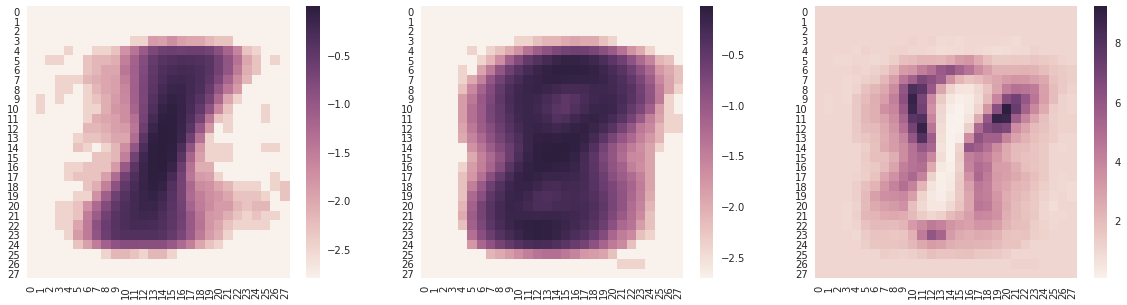

In [92]:
def odds_ratio(c1, c2):
    mapSize = c1.hMap.mapSize
    odds = np.empty((mapSize, mapSize))
    for x in range(mapSize):
        for y in range(mapSize):
            odds[x,y]= math.log10(c1.single_probability(x,y,'#'))/math.log10(c2.single_probability(x,y,'#'))
    return odds
def log_likelihood(classifier):
    mapSize = classifier.hMap.mapSize
    return [[math.log10(classifier.single_probability(x,y,'#')) for y in range(mapSize)] for x in range(mapSize)]
fig, ax = plt.subplots(figsize=(20,5),ncols=3, nrows=1)
sns.heatmap(log_likelihood(classifiers[1]), ax=ax[0])
sns.heatmap(log_likelihood(classifiers[8]), ax=ax[1])
sns.heatmap(odds_ratio(classifiers[1],classifiers[8]), ax=ax[2])